<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/dataset/notebooks/3.0-mb-data_preprocessing_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gcsfs==2022.10.0
#!pip install wandb==0.13.4
!pip install scikit-learn==1.1.3
!pip install SciencePlots==1.0.9
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

In [227]:
import os
import random



import gcsfs
import google.auth
from google.colab import auth

import numpy as np
from numpy.testing import assert_almost_equal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from pandas._testing.asserters import assert_almost_equal
import pandas as pd

from scipy import stats
from scipy.stats import kurtosis, skew

import seaborn as sns

#import wandb


In [43]:
# set N used in n-largest or smallest
N = 10

In [3]:
# plt.style.use(['science','no-latex', 'nature'])
plt.style.use("seaborn")
ratio = (16,9)

# Set color theme
highlight_color = "#1ebeff"
contrast_color = '#fae042'

custom_palette = LinearSegmentedColormap.from_list(" ",  [highlight_color,  '#ffffff', contrast_color])
plt.cm.register_cmap("custom_palette", custom_palette)

In [4]:
# connect to weights and biases
# run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

# dataset = wandb.Artifact(name="train_val_test", type="preprocessed_data")


In [5]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [6]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


In [7]:
# replace with sampled data set later
data = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_2017.parquet"
)

data = data.sample(frac=0.1, axis=0)


## Notes on Data Set 🗃️

**Overview on ticker symbols in 🇺:**
- `others` probably identified by `.`. Index probably identified by `^` e. g., `^NDX` for Nasdq. The `SPY` ETF is however just `SPY`.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, Distributions, Memory 🔭

In [8]:
data.head()

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
48882212,ABT,2017-05-15 15:36:42,88642482,ABT,2017-11-17,47.0,C,4,0.87,0.87,...,0.86,228.0,21.0,0.76,0.86,115183536.0,4.0,0.61,1.18,-1
47618832,SPY,2017-03-06 10:26:44,37841738,SPY,2017-04-07,228.0,P,10,0.67,0.67,...,0.67,110.0,111.0,0.72,0.65,115003704.0,13.0,0.66,0.68,-1
47717538,AMGN,2017-03-10 15:18:50,122749302,AMGN,2017-03-17,192.5,C,4,0.40,0.37,...,0.35,32.0,14.0,0.41,0.41,114830392.0,83.0,0.42,0.27,1
48938399,JPM,2017-05-17 14:37:17,95815106,JPM,2018-01-19,87.5,C,2,4.26,4.20,...,4.05,35.0,32.0,4.40,4.25,113832320.0,4.0,4.40,5.16,1
46820048,^CDD,2017-01-20 10:23:29,17513184,CDD,2017-01-27,133.0,P,2,0.44,0.44,...,0.44,100.0,100.0,0.35,0.67,114336288.0,2.0,0.35,0.67,-1


In [9]:
data.describe()

,SEQUENCE_NUMBER,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,order_id,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
count,2.695410e+05,269541.000000,269541.000000,269541.000000,269541.000000,269541.000000,2.695410e+05,269266.000000,269266.000000,269266.000000,269266.000000,259703.000000,262967.000000,2.695130e+05,269541.000000,234513.000000,235283.000000,269541.000000
mean,9.736198e+07,187.154236,10.719894,5.223831,5.051800,5.398413,3.992416e+08,5.526865,4.972250,87.788643,94.563164,5.247066,5.174757,1.139807e+08,74.320061,5.369322,5.315793,-0.028845
std,1.542080e+08,593.298462,78.512763,20.363462,20.120657,20.608505,2.878996e+07,20.689854,20.058012,237.733704,237.828918,20.321445,19.993250,1.779354e+06,372.239136,20.901094,19.799931,0.999586
min,4.240000e+02,0.500000,1.000000,0.010000,0.000000,0.000000,3.483784e+08,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,1.052738e+08,1.000000,0.010000,0.010000,-1.000000
25%,3.094532e+07,35.000000,1.000000,0.330000,0.270000,0.390000,3.742622e+08,0.440000,0.230000,10.000000,12.000000,0.350000,0.350000,1.135536e+08,3.000000,0.350000,0.400000,-1.000000
50%,6.872388e+07,67.500000,3.000000,1.150000,1.050000,1.240000,3.999829e+08,1.330000,1.000000,25.000000,31.000000,1.180000,1.170000,1.144504e+08,10.000000,1.180000,1.250000,-1.000000
75%,1.107177e+08,127.000000,9.000000,3.460000,3.300000,3.650000,4.243002e+08,3.990000,3.200000,72.000000,82.000000,3.500000,3.450000,1.150793e+08,30.000000,3.540000,3.600000,1.000000
max,2.245539e+09,6300.000000,25000.000000,1082.000000,1076.000000,1082.000000,4.475126e+08,1082.000000,1073.000000,5882.000000,5529.000000,1109.000000,897.369995,1.285364e+08,30000.000000,1646.699951,897.369995,1.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269541 entries, 48882212 to 47953648
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UNDERLYING_SYMBOL  269541 non-null  object        
 1   QUOTE_DATETIME     269541 non-null  datetime64[ns]
 2   SEQUENCE_NUMBER    269541 non-null  int64         
 3   ROOT               269541 non-null  object        
 4   EXPIRATION         269541 non-null  datetime64[ns]
 5   STRK_PRC           269541 non-null  float32       
 6   OPTION_TYPE        269541 non-null  category      
 7   TRADE_SIZE         269541 non-null  int64         
 8   TRADE_PRICE        269541 non-null  float32       
 9   BEST_BID           269541 non-null  float32       
 10  BEST_ASK           269541 non-null  float32       
 11  order_id           269541 non-null  int64         
 12  ask_ex             269266 non-null  float32       
 13  bid_ex             269266 non-null 

In [11]:
print(data.shape)

(269541, 23)


In [12]:
print(data.shape)
# drop identical rows, if present 
data.drop_duplicates(inplace=True)
print(data.shape)

(269541, 23)
(269541, 23)


In [13]:
data.nunique()

UNDERLYING_SYMBOL      2744
QUOTE_DATETIME       230307
SEQUENCE_NUMBER      266972
ROOT                   2795
EXPIRATION               74
STRK_PRC               1456
OPTION_TYPE               2
TRADE_SIZE              606
TRADE_PRICE            8094
BEST_BID               4528
BEST_ASK               4575
order_id             269541
ask_ex                 4633
bid_ex                 4500
bid_size_ex            2560
ask_size_ex            2525
price_all_lead         7432
price_all_lag          7454
optionid              70953
day_vol                1631
price_ex_lead          7748
price_ex_lag           7670
buy_sell                  2
dtype: int64

In [14]:
data.head().T

,48882212,47618832,47717538,48938399,46820048
UNDERLYING_SYMBOL,ABT,SPY,AMGN,JPM,^CDD
QUOTE_DATETIME,2017-05-15 15:36:42,2017-03-06 10:26:44,2017-03-10 15:18:50,2017-05-17 14:37:17,2017-01-20 10:23:29
SEQUENCE_NUMBER,88642482,37841738,122749302,95815106,17513184
ROOT,ABT,SPY,AMGN,JPM,CDD
EXPIRATION,2017-11-17 00:00:00,2017-04-07 00:00:00,2017-03-17 00:00:00,2018-01-19 00:00:00,2017-01-27 00:00:00
STRK_PRC,47.0,228.0,192.5,87.5,133.0
OPTION_TYPE,C,P,C,C,P
TRADE_SIZE,4,10,4,2,2
TRADE_PRICE,0.87,0.67,0.4,4.26,0.44
BEST_BID,0.87,0.67,0.37,4.2,0.44


## Correlations and Collinearity🎲

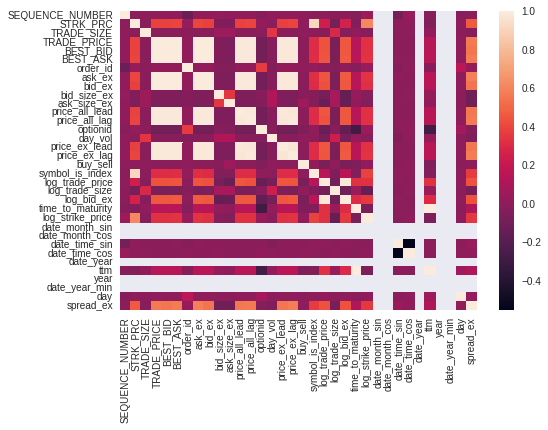

In [228]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

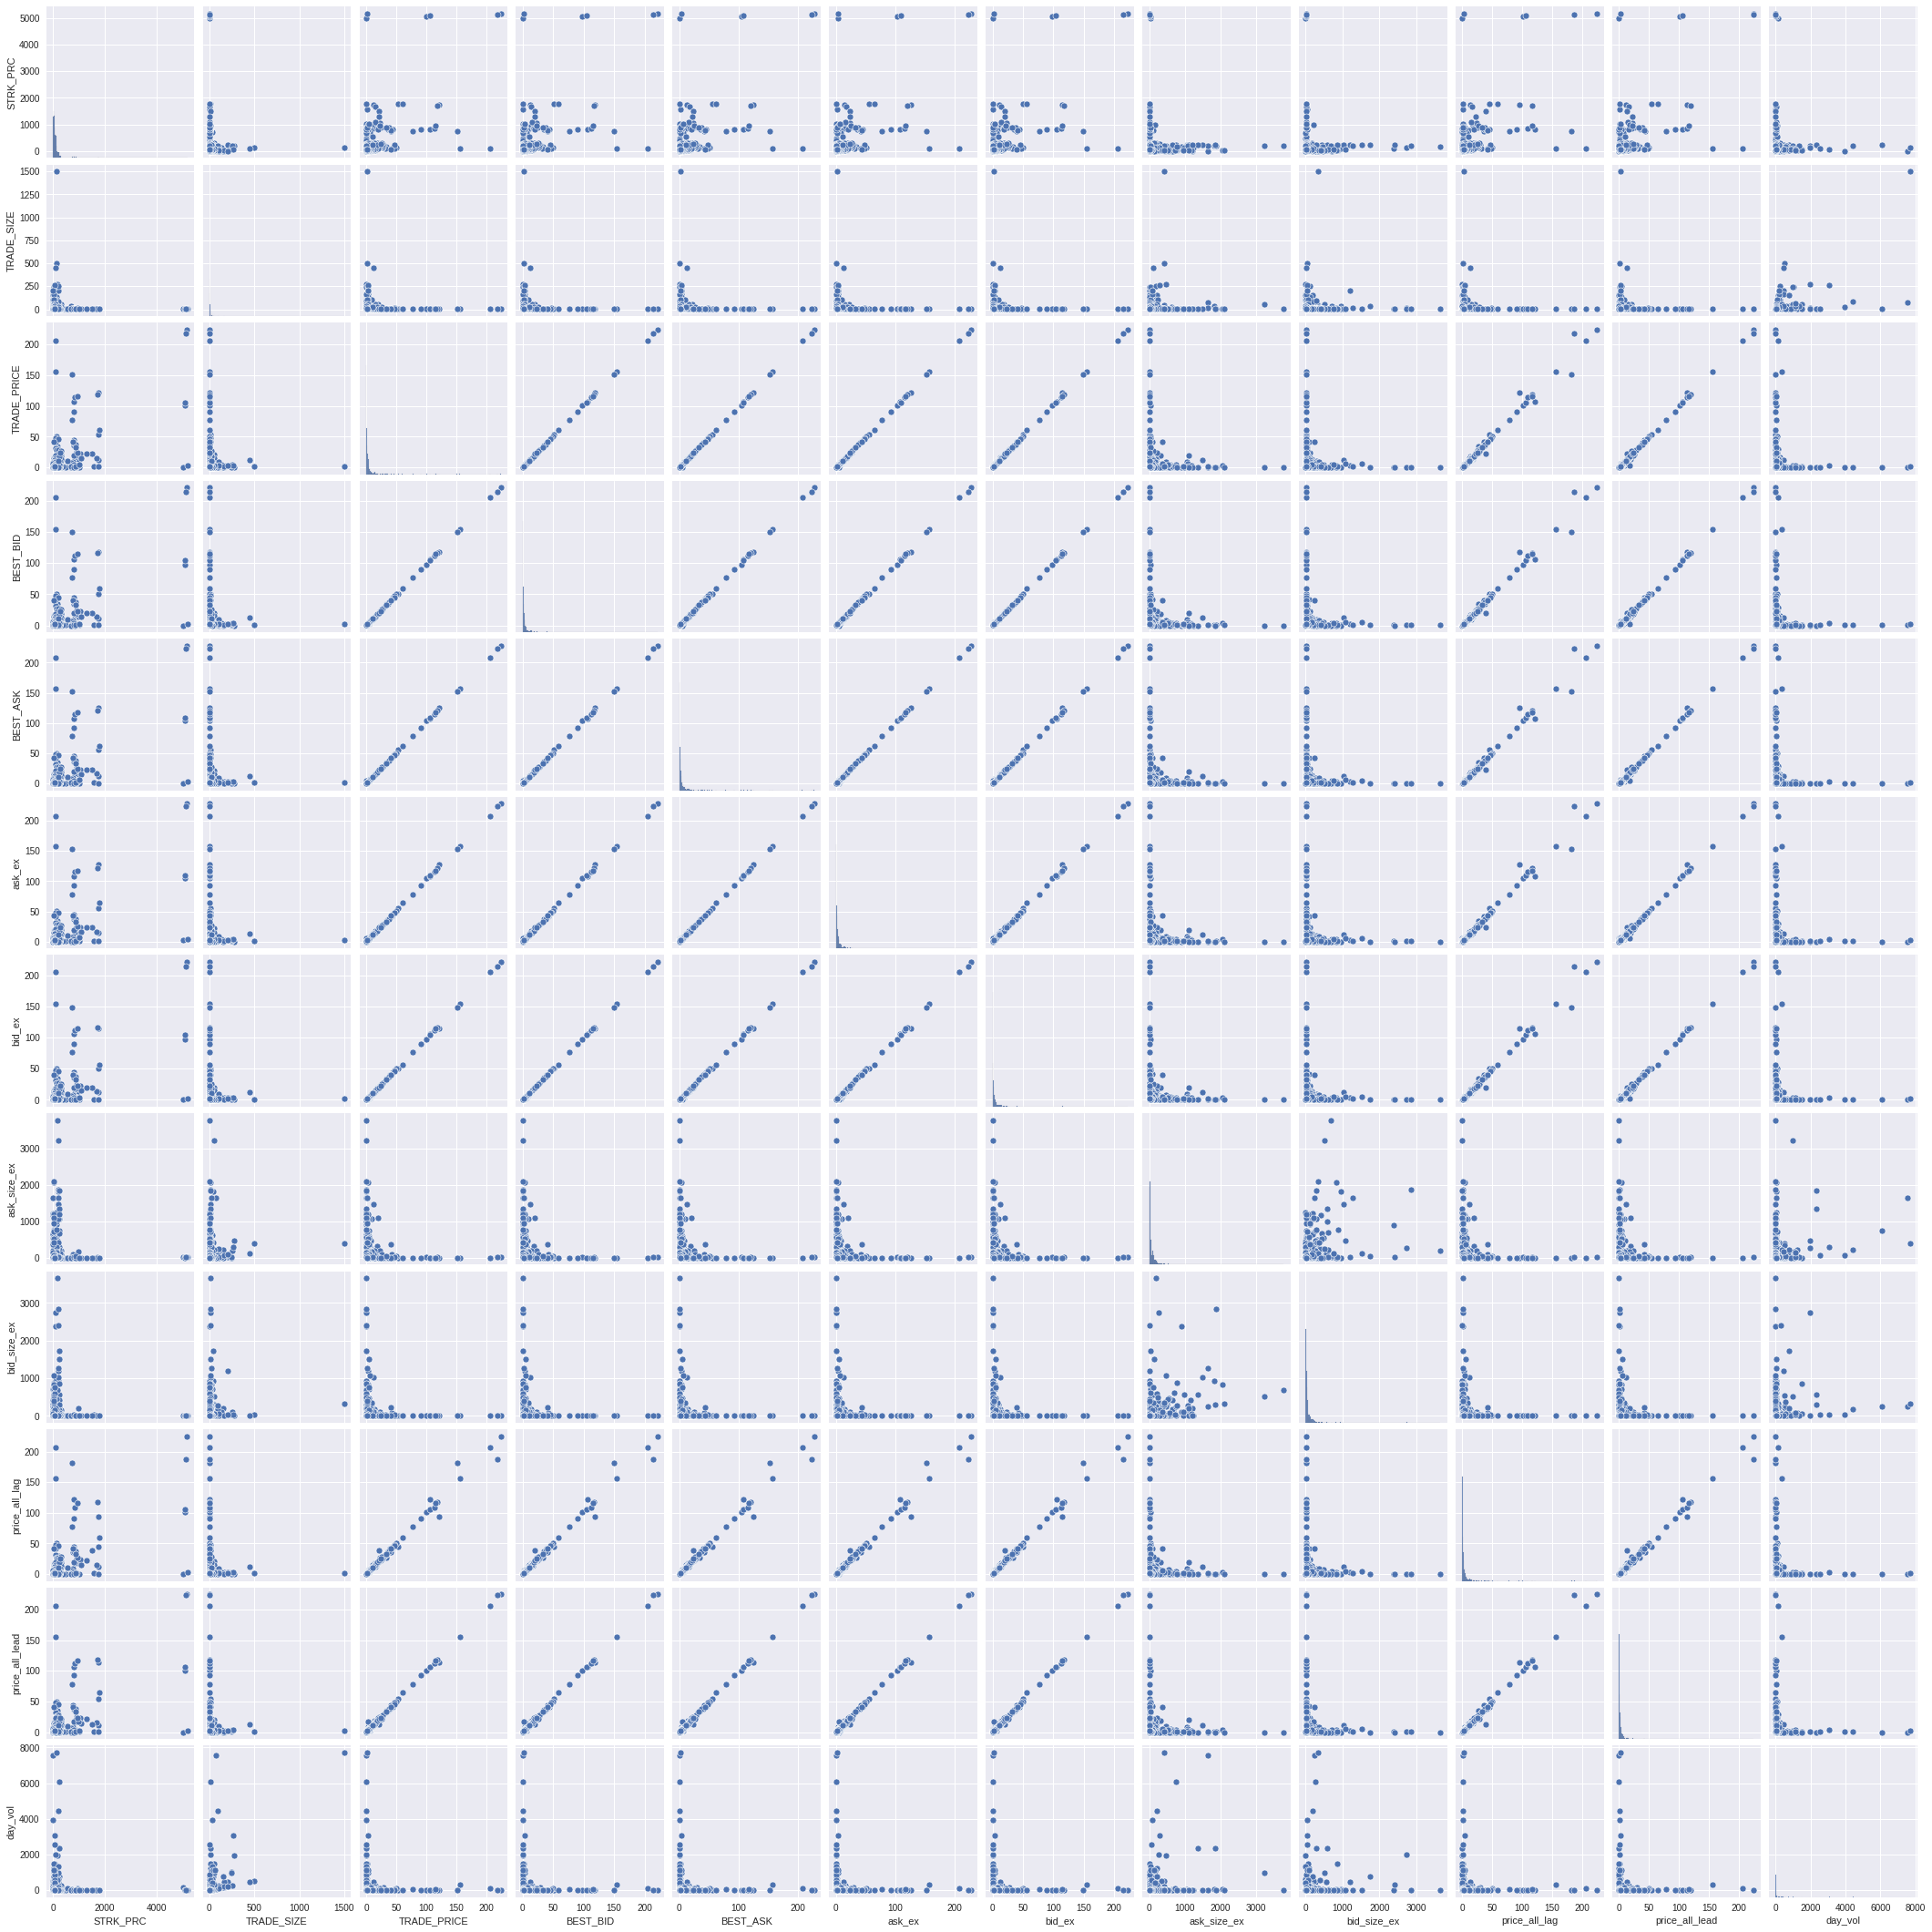

In [16]:
sample = data.sample(n=1000)
sns.pairplot(sample, vars=["STRK_PRC","TRADE_SIZE", "TRADE_PRICE", "BEST_BID", "BEST_ASK", "ask_ex", "bid_ex", "ask_size_ex", "bid_size_ex", "price_all_lag", "price_all_lead", "day_vol"])

In [ ]:
# TODO: add collinearity plots

## Preparation 🥗

### Add Positional Encoding

In [114]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24*60*60
seconds = (data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()).dt.total_seconds()

data["date_time_sin"] = np.sin(2*  np.pi* seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi* seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M")
    - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date

### Factorize dates

In [92]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2005, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [0, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)

## Trades over Time ⌚

In [ ]:
# TODO: Add recession data to time plots

In [239]:
trades_per_day = data[["TRADE_PRICE"]].groupby(data["date"]).count()

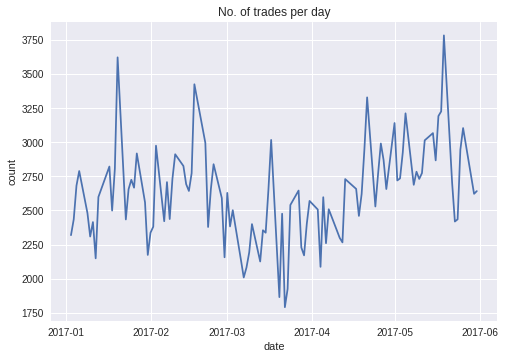

In [241]:
ax = sns.lineplot(data=trades_per_day,x="date", y="TRADE_PRICE")
ax.yaxis.label.set_text("count")
ax.title.set_text("No. of trades per day")

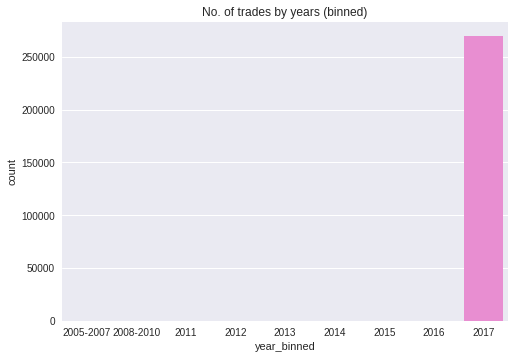

In [242]:
ax = sns.countplot(data=data, x = "year_binned")
ax.title.set_text("No. of trades by years (binned)")

# Buy Sell 👛

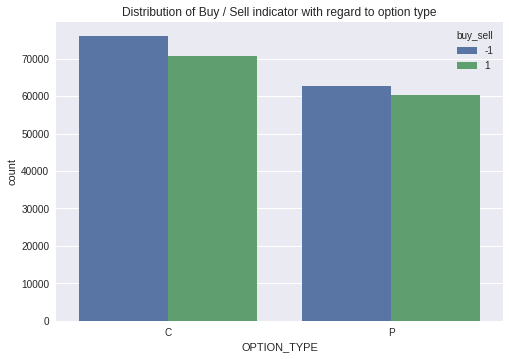

In [183]:
ax = sns.countplot(data=data,x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")

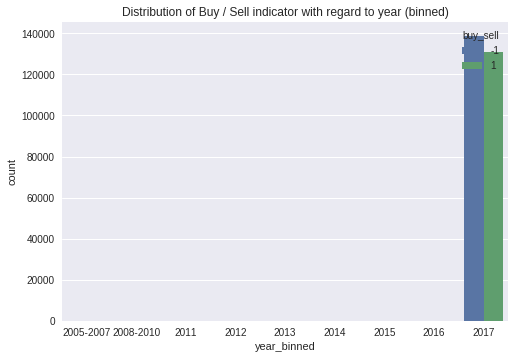

In [181]:
ax = sns.countplot(data=data,x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")

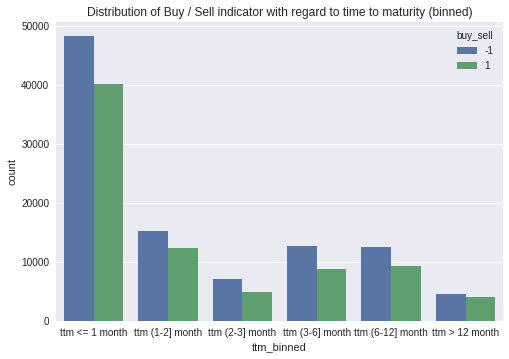

In [182]:
ax = sns.countplot(data=data,x="ttm_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to time to maturity (binned)")

In [178]:
trades_over_time = data[["buy_sell"]].value_counts()
trades_over_time = trades_over_time / trades_over_time.sum()

trades_over_time

buy_sell
-1          0.514423
 1          0.485577
dtype: float64

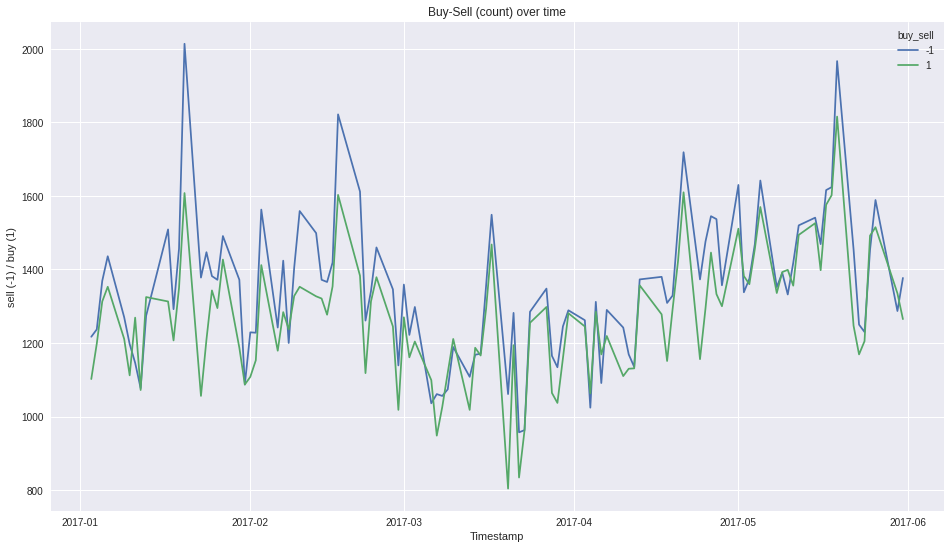

In [210]:
trades_over_time = data.groupby(data['date'])["buy_sell"].value_counts().unstack(fill_value=0)
trades_over_time.plot(kind="line", figsize=ratio, title="Buy-Sell (count) over time", xlabel="Timestamp", ylabel="sell (-1) / buy (1)")

# $n$ Most Frequent Symbols, Indices, and Special Codes 🔢

,Symbol,Count
0,SPY,8428
1,AMZN,4780
2,IWM,3881
3,AAPL,3284
4,TSLA,3184
5,^NDX,3095
6,QQQ,2873
7,FB,2846
8,SVXY,2826
9,NVDA,2779


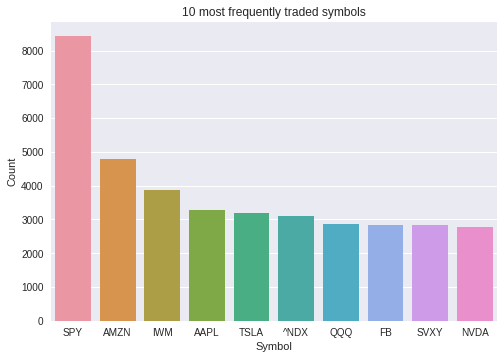

In [48]:
most_frequent_symbols = data["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")
most_frequent_symbols

In [110]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()

In [138]:
frequent_symbols_over_time = data[data["UNDERLYING_SYMBOL"].isin(list_freq_symbols)]

In [216]:
frequent_symbols_trades_per_day = frequent_symbols_over_time.groupby([frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period('m'), "UNDERLYING_SYMBOL"])["TRADE_SIZE"].count().reset_index().rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date"})


In [157]:
frequent_symbols_trades_per_day.head()

,date,UNDERLYING_SYMBOL,count
0,2017-01,AAPL,522
1,2017-01,AMZN,942
2,2017-01,FB,559
3,2017-01,IWM,644
4,2017-01,NVDA,471


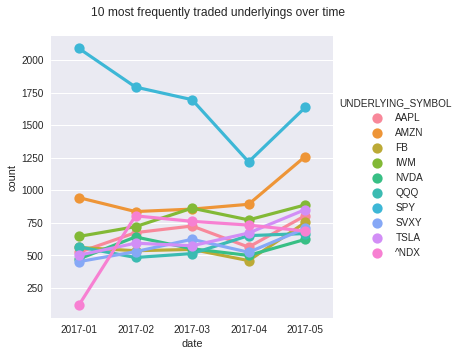

In [170]:
plot = sns.catplot(data=frequent_symbols_trades_per_day, x="date", y="count", hue='UNDERLYING_SYMBOL', kind="point")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle(f"{N} most frequently traded underlyings over time");

In [113]:
frequent_symbols_over_time

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,date_time_sin,date_time_cos,date_year,ttm,year,date_year_min,day,TRADE_SIZE_binned,year_binned,ttm_binned
47618832,SPY,2017-03-06 10:26:44,37841738,SPY,2017-04-07,228.0,P,10,0.670000,0.670000,...,0.395813,-0.918331,1.0,1,2017,1.0,6,"(5,11]",2017,ttm <= 1 month
48803262,NVDA,2017-05-11 10:27:47,37099395,NVDA,2018-01-19,125.0,P,1,15.120000,15.050000,...,0.391601,-0.920135,1.0,8,2017,1.0,11,"(0,1]",2017,ttm (6-12] month
48614372,TSLA,2017-05-02 13:33:55,107852713,TSLA,2017-05-05,305.0,C,9,19.190001,18.950001,...,-0.398416,-0.917205,1.0,0,2017,1.0,2,"(5,11]",2017,NaN
46911460,SPY,2017-01-25 11:20:49,126312682,SPY,2017-06-30,235.0,C,4,3.910000,3.880000,...,0.170138,-0.985420,1.0,5,2017,1.0,25,"(3,5]",2017,ttm (3-6] month
47885134,^NDX,2017-03-21 14:41:49,112554353,NDX,2017-04-13,5575.0,C,1,2.080000,1.100000,...,-0.648840,-0.760925,1.0,1,2017,1.0,21,"(0,1]",2017,ttm <= 1 month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46619423,FB,2017-01-09 10:06:44,82721738,FB,2017-01-20,131.0,C,8,0.150000,0.140000,...,0.474344,-0.880339,1.0,0,2017,1.0,9,"(5,11]",2017,NaN
47299188,FB,2017-02-15 10:23:04,85015402,FB,2017-03-03,120.0,P,2,0.100000,0.090000,...,0.410454,-0.911881,1.0,1,2017,1.0,15,"(1,3]",2017,ttm <= 1 month
47734593,SPY,2017-03-13 13:12:39,91236390,SPY,2017-04-21,228.0,C,2,9.830000,9.780000,...,-0.311713,-0.950176,1.0,1,2017,1.0,13,"(1,3]",2017,ttm <= 1 month
46598835,FB,2017-01-06 12:13:48,113057023,FB,2017-01-06,116.0,C,1,7.270000,7.200000,...,-0.060177,-0.998188,1.0,0,2017,1.0,6,"(0,1]",2017,NaN


In [37]:
data["symbol_is_index"] = data['UNDERLYING_SYMBOL'].str.startswith("^")

,Symbol,Count
0,^NDX,3095
1,^EUU,14
2,^CDD,12
3,^EUI,8
4,^YUK,8
5,^BPX,5
6,^GBP,3
7,^MNX,1
8,^SKA,1
9,^BRB,1


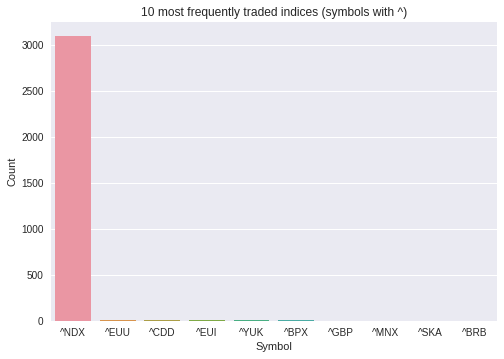

In [49]:
most_frequent_indices = data[data["symbol_is_index"]]["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_indices.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_indices, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded indices (symbols with ^)")
most_frequent_indices

In [17]:
# 5th character in symbol
data["special_code"] = data['UNDERLYING_SYMBOL'].str[4]

In [18]:
data["special_code"].value_counts(dropna=False)

NaN    265916
L        2443
B         609
A         560
K           9
Y           4
Name: special_code, dtype: int64

**Observation:**
* `L`: Misc. (compare Google Shares)
* `B`: Class "B"
* `A`: Class "A"
* `K`: "Non-voting"
* `X`: "Mutual funds"
* `Y`: "ADRs"

Grauer et al. also include ETFs in `others`. Not sure how they are identified.

In [199]:
# Security type similar to Grauer et. al p. 35
data['security_type'] = np.where(data["symbol_is_index"],"index option", np.where(data["special_code"].notnull(),"other", "stock option"))
data['security_type'] = data['security_type'].astype("category")

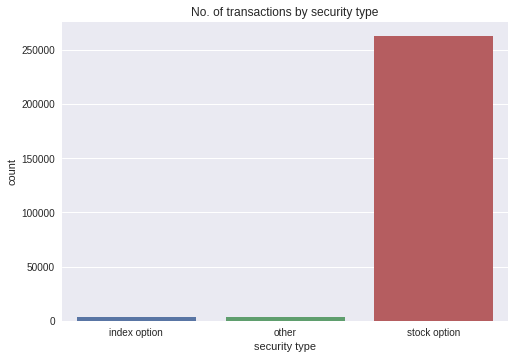

In [200]:
ax = sns.countplot(data=data,x="security_type")
ax.title.set_text("No. of transactions by security type")
ax.xaxis.label.set_text("security type")

# Trade Prices and Sizes 🤝

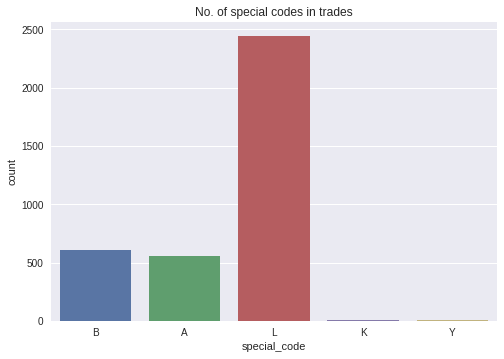

In [51]:
ax = sns.countplot(data=data, x = "special_code")
ax.title.set_text("No. of special codes in trades")

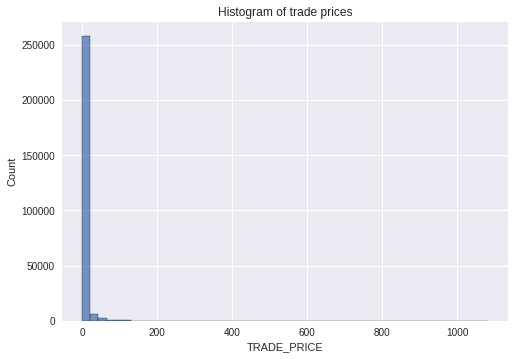

In [20]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)
ax.title.set_text("Histogram of trade prices")

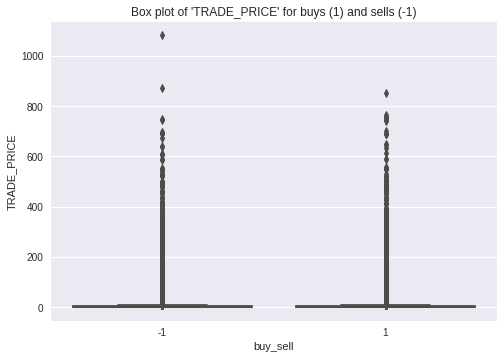

In [171]:
ax = sns.boxplot(data = data, x="buy_sell", y = "TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few very large trade prices, many very small trade prices.
* Scaling can problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform. Could improve results.

In [52]:
data['log_trade_price'] = np.log(data["TRADE_PRICE"])

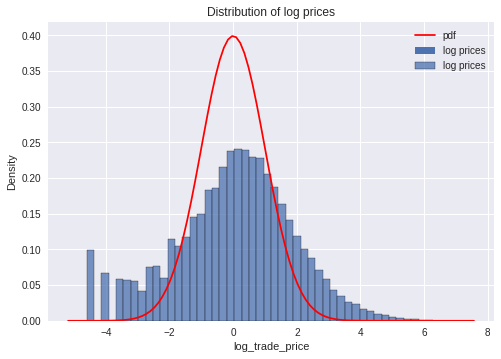

In [172]:
ax = sns.histplot(data, x= "log_trade_price", bins=50, stat='density', label="log prices")

# extract the limits for the x-axis
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf,"r", label='pdf')
ax.title.set_text("Distribution of log prices")                                                   
ax.legend()

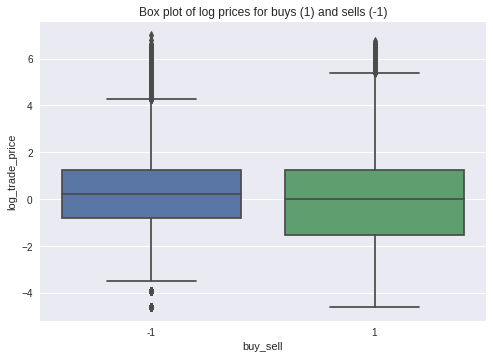

In [174]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")

In [56]:
data.nlargest(N, "TRADE_PRICE", keep='first').T

,47219421,47749761,47546716,48222638,47413723,47313135,47313128,47301722,47961622,47302155
UNDERLYING_SYMBOL,^NDX,^NDX,^NDX,^NDX,PCLN,^NDX,^NDX,^NDX,^NDX,^NDX
QUOTE_DATETIME,2017-02-10 11:07:14,2017-03-14 11:00:41,2017-03-01 10:51:45,2017-04-11 10:44:04,2017-02-22 09:38:56,2017-02-15 14:19:53,2017-02-15 14:19:51,2017-02-15 10:57:37,2017-03-27 10:14:05,2017-02-15 11:03:47
SEQUENCE_NUMBER,83598560,20974195,84181782,554467781,5487416,96878583,96876853,79986322,7810098,80573200
ROOT,NDX,NDX,NDX,NDX,PCLN,NDX,NDX,NDX,NDX,NDX
EXPIRATION,2017-12-15 00:00:00,2017-03-31 00:00:00,2017-04-21 00:00:00,2017-04-21 00:00:00,2018-01-19 00:00:00,2017-03-17 00:00:00,2017-03-17 00:00:00,2017-04-21 00:00:00,2017-04-21 00:00:00,2017-04-21 00:00:00
STRK_PRC,4200.0,4500.0,4520.0,4600.0,2400.0,4540.0,4540.0,4540.0,4600.0,4540.0
OPTION_TYPE,C,C,C,C,P,C,C,C,C,C
TRADE_SIZE,3,1,1,1,1,1,1,1,1,1
TRADE_PRICE,1082.0,873.349976,854.549988,764.72998,756.299988,752.609985,752.419983,747.830017,747.22998,747.200012
BEST_BID,1076.0,869.0,850.700012,760.400024,751.299988,748.400024,748.400024,742.0,742.400024,743.599976


In [237]:
data.nsmallest(N, "TRADE_PRICE", keep='first').T

,46843089,47756316,46967473,48818557,48757233,48610011,48388868,47743276,48044400,47310795
UNDERLYING_SYMBOL,SPY,X,FCX,BAC,VXX,NFLX,WDC,JACK,X,NKE
QUOTE_DATETIME,2017-01-20 15:11:21,2017-03-14 13:14:13,2017-01-27 11:45:31,2017-05-11 14:49:39,2017-05-09 13:25:21,2017-05-02 12:05:55,2017-04-20 15:12:08,2017-03-14 09:34:23,2017-03-30 15:32:16,2017-02-15 13:39:15
SEQUENCE_NUMBER,223021153,797694434,28996697,123732219,62024765,47002741,151705018,6192199,149763337,58317862
ROOT,SPY,X,FCX,BAC,VXX,NFLX,WDC,JACK,X,NKE
EXPIRATION,2017-02-10 00:00:00,2017-03-17 00:00:00,2017-01-27 00:00:00,2017-05-12 00:00:00,2017-05-12 00:00:00,2017-05-05 00:00:00,2017-04-21 00:00:00,2017-03-17 00:00:00,2017-04-21 00:00:00,2017-02-17 00:00:00
STRK_PRC,252.5,43.5,17.0,23.5,12.0,143.0,87.5,120.0,23.0,50.0
OPTION_TYPE,C,C,C,P,P,P,C,C,P,P
TRADE_SIZE,30,1,1,94,2,100,6,10,1,9
TRADE_PRICE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
BEST_BID,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


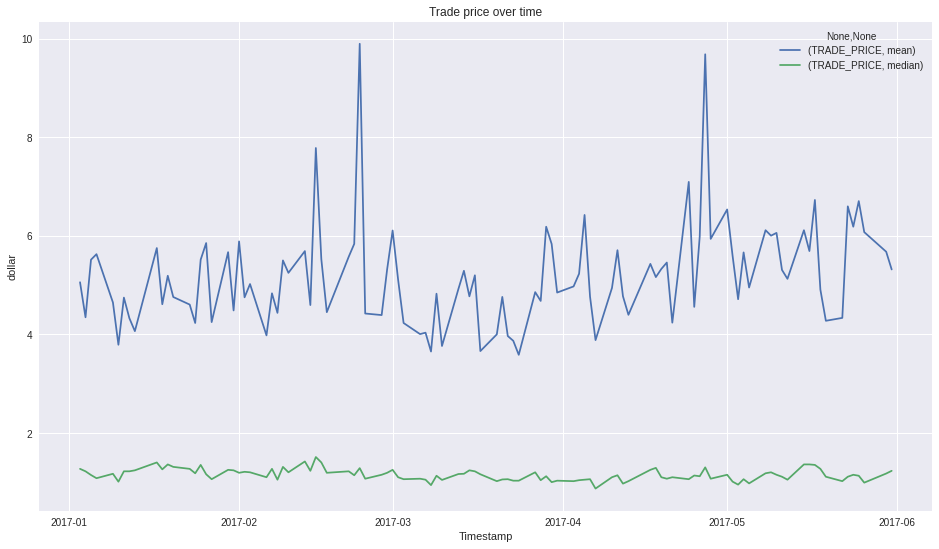

In [217]:
trades_over_time = data[["TRADE_PRICE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade price over time", xlabel="Timestamp", ylabel="dollar")

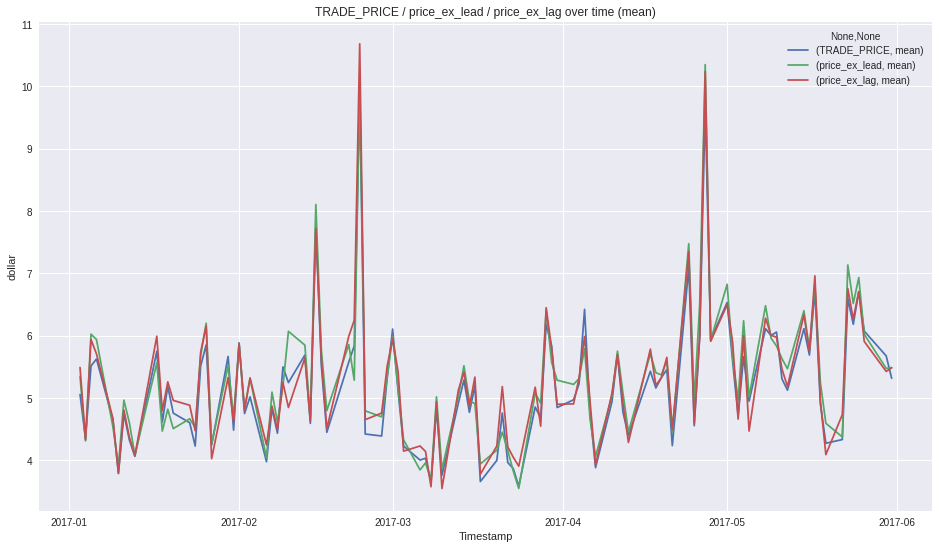

In [218]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (mean)", xlabel="Timestamp", ylabel="dollar")

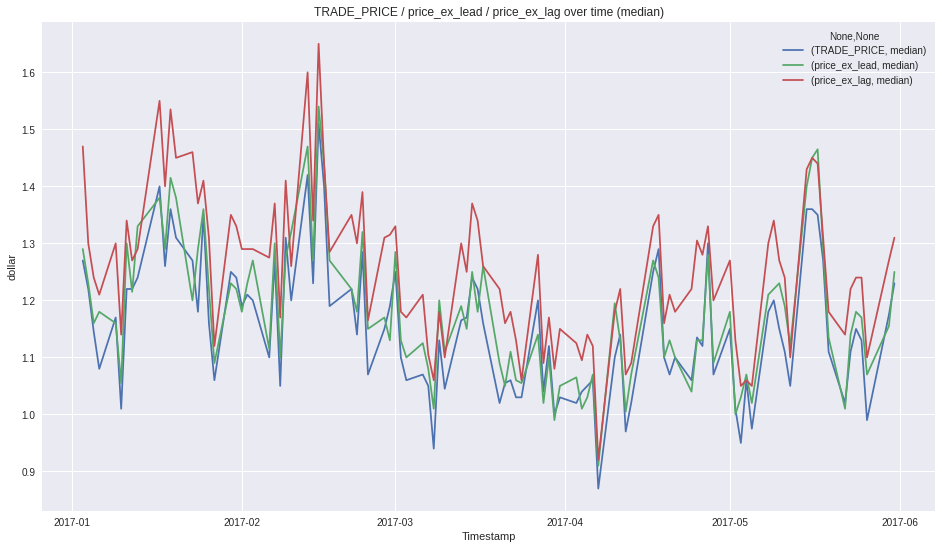

In [219]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['median'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (median)", xlabel="Timestamp", ylabel="dollar")

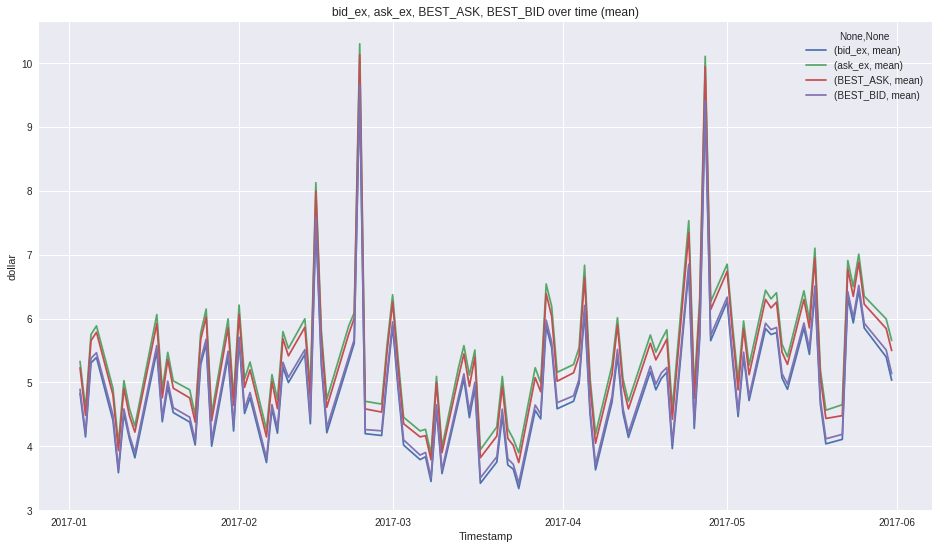

In [220]:
lead_lag_trade_price = data[["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="bid_ex, ask_ex, BEST_ASK, BEST_BID over time (mean)", xlabel="Timestamp", ylabel="dollar")

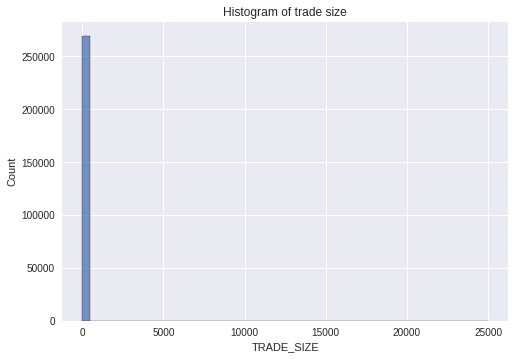

In [62]:
# Think about outliers
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)
ax.title.set_text("Histogram of trade size")

**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform helps a little bit.

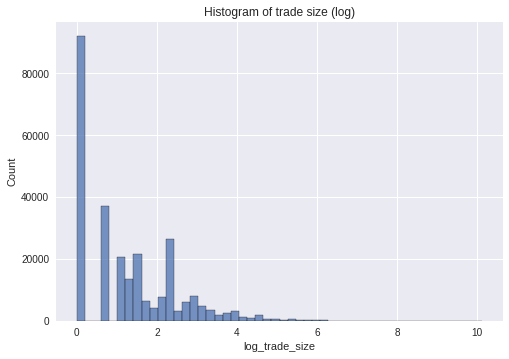

In [63]:
data['log_trade_size'] = np.log(data["TRADE_SIZE"])
ax = sns.histplot(data, x="log_trade_size", bins=50)
ax.title.set_text("Histogram of trade size (log)")

In [64]:
data.nlargest(N, "TRADE_SIZE", keep='first').T

,47685630,48881325,48617031,46579974,46810317,48669090,48907850,47803344,47280783,46679455
UNDERLYING_SYMBOL,USO,T,SVXY,SPY,MYL,XOP,FEZ,QQQ,EEM,EEM
QUOTE_DATETIME,2017-03-09 12:27:37,2017-05-15 15:22:08,2017-05-02 14:26:22,2017-01-05 14:33:43,2017-01-19 15:34:08,2017-05-04 12:47:38,2017-05-16 14:52:00,2017-03-16 12:17:51,2017-02-14 12:25:55,2017-01-11 14:22:17
SEQUENCE_NUMBER,103566190,123397990,41980195,98534881,77679182,77978927,65578375,32687169,35170843,128512104
ROOT,USO,T,SVXY,SPY,MYL,XOP,FEZ,QQQ,EEM,EEM
EXPIRATION,2017-06-16 00:00:00,2017-07-21 00:00:00,2018-01-19 00:00:00,2017-02-17 00:00:00,2017-07-21 00:00:00,2017-07-21 00:00:00,2017-08-18 00:00:00,2018-01-19 00:00:00,2017-04-21 00:00:00,2017-02-10 00:00:00
STRK_PRC,10.5,42.0,25.0,207.0,40.0,40.0,37.0,110.0,34.0,36.5
OPTION_TYPE,P,C,P,P,C,C,C,P,P,P
TRADE_SIZE,25000,16773,7535,7119,6000,5000,5000,4000,4000,3417
TRADE_PRICE,0.7,0.09,0.24,0.38,2.32,0.26,2.88,2.02,0.16,0.74
BEST_BID,0.7,0.06,0.05,0.37,2.24,0.23,2.75,2.0,0.16,0.73


# Bid, Ask, and Spread 🛍️

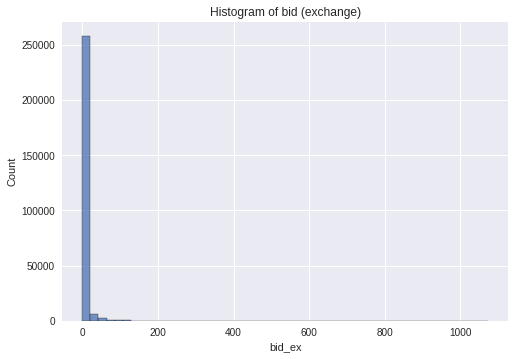

In [65]:
ax = sns.histplot(data, x="bid_ex", bins=50)
ax.title.set_text("Histogram of bid (exchange)")

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


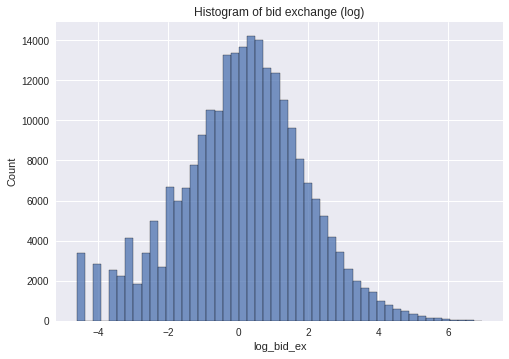

In [66]:
data['log_bid_ex'] = np.log(data["bid_ex"])
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

In [205]:
data['spread_ex'] = data['ask_ex'] - data['bid_ex']

In [234]:
mean_spread = data["spread_ex"].groupby(data['date']).agg(['mean'])

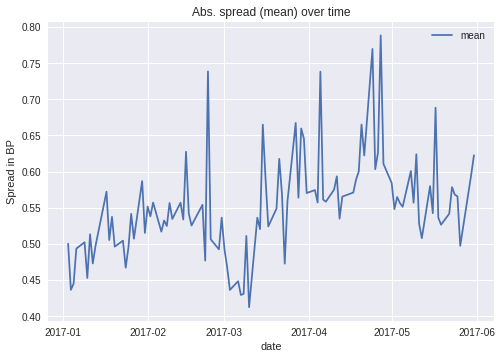

In [235]:
ax = sns.lineplot(mean_spread)
ax.title.set_text("Abs. spread (mean) over time")
ax.yaxis.label.set_text("Spread in BP")

# Time to Maturity ⌚

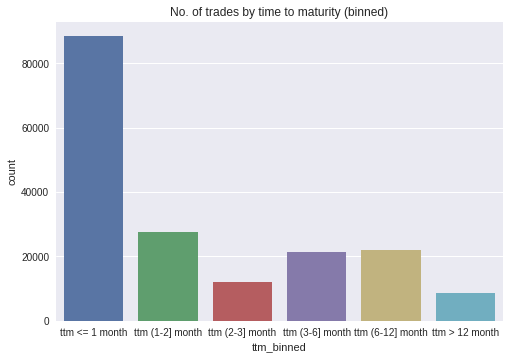

In [238]:
ax = sns.countplot(data=data, x = "ttm_binned")
ax.title.set_text("No. of trades by time to maturity (binned)")

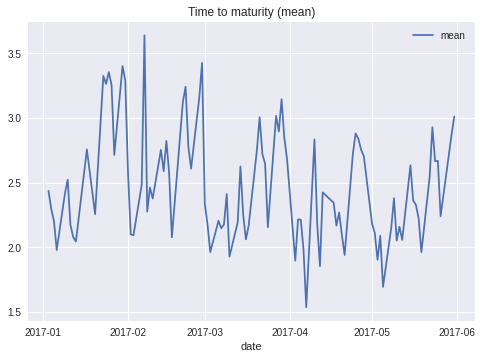

In [236]:
mean_time_2_maturity = data["ttm"].groupby(data['date']).agg(['mean'])
ax = sns.lineplot(mean_time_2_maturity)
ax.title.set_text("Time to maturity (mean)")

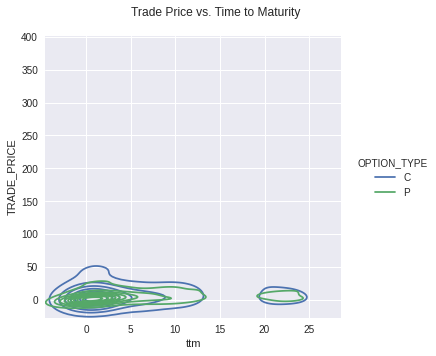

In [169]:
sample = data.sample(n=1000)

plot = sns.displot(data = sample, 
                x = "ttm", 
                y = "TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity");

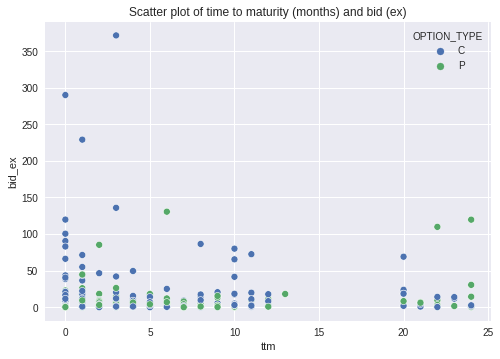

In [189]:
ax = sns.scatterplot(data = sample, 
                x = "ttm", 
                y = "bid_ex",
                hue= "OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")

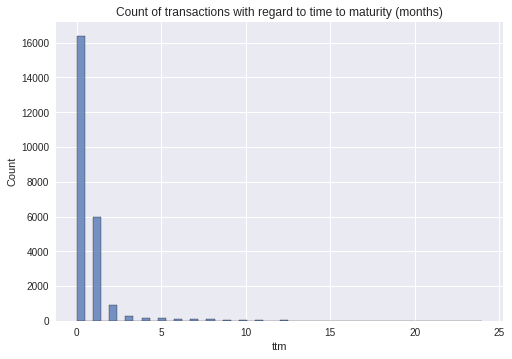

In [187]:
ax = sns.histplot(data = data[data["bid_ex"]==0.0], 
                  x = "ttm", bins=50)
ax.title.set_text("Count of transactions with regard to time to maturity (months)")

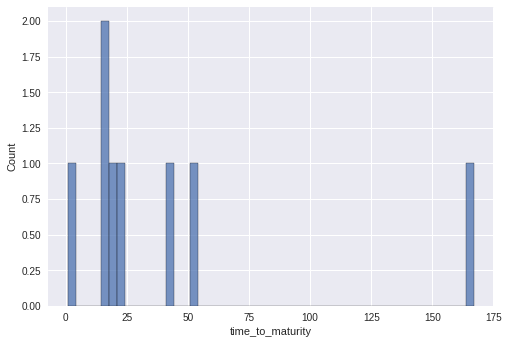

In [74]:
# TODO: ask of zero plausible?
sns.histplot(data = data[data["ask_ex"]==0.0], 
                x = "ttm", bins=50)

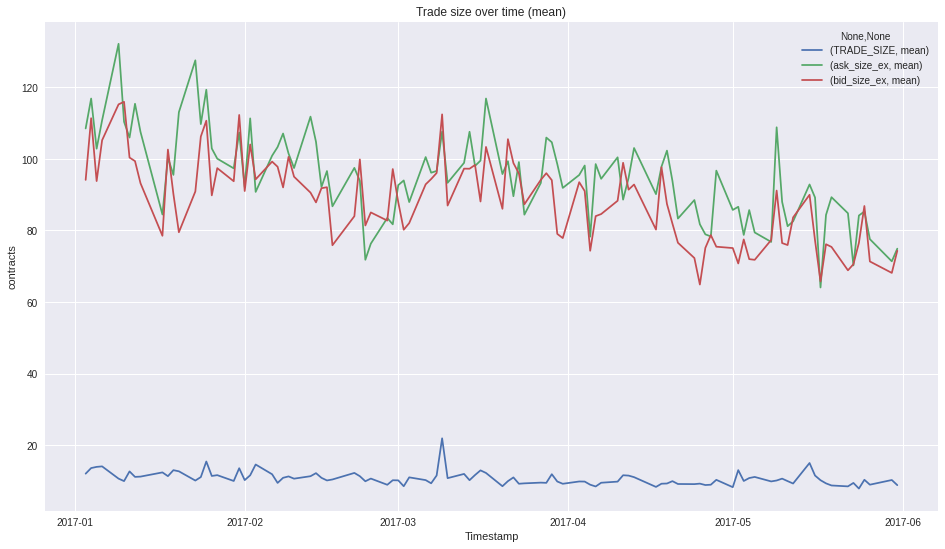

In [221]:
trades_over_time = data[["TRADE_SIZE", "ask_size_ex", "bid_size_ex"]].groupby(data['date']).agg(['mean'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time (mean)", xlabel="Timestamp", ylabel="contracts")

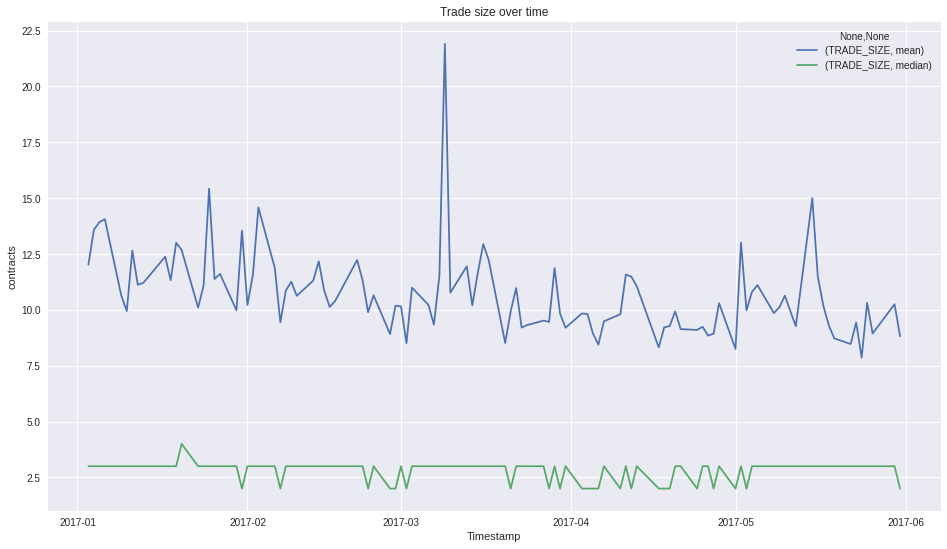

In [222]:
trades_over_time = data[["TRADE_SIZE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time", xlabel="Timestamp", ylabel="contracts")

# Strike Price 💷

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab10b96c90>]],
      dtype=object)

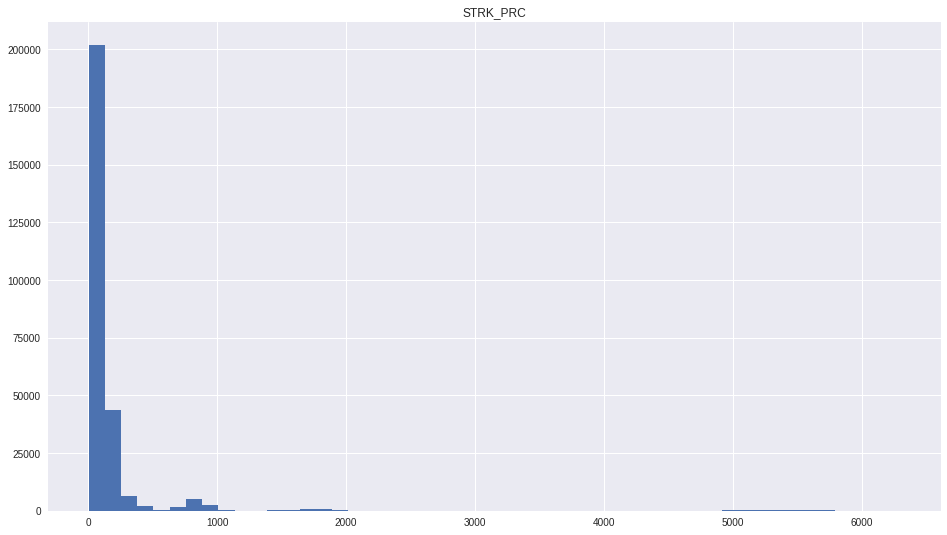

In [82]:
data[["STRK_PRC"]].hist(figsize=ratio, bins=50)

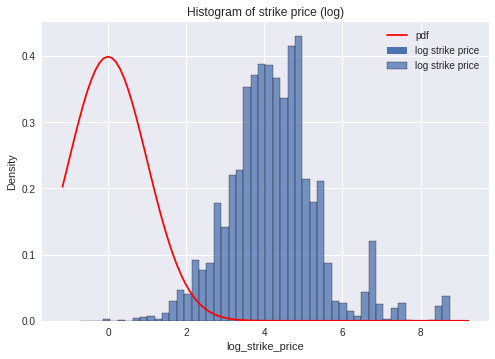

In [224]:
data['log_strike_price'] = np.log(data["STRK_PRC"])

ax = sns.histplot(data, x= "log_strike_price", bins=50, stat='density', label="log strike price")
ax.title.set_text("Histogram of strike price (log)")

# extract the limits for the x-axis
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf,  "r", label='pdf')                                                   
ax.legend()

# NaNs 🪲

In [225]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots(figsize=ratio)
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()

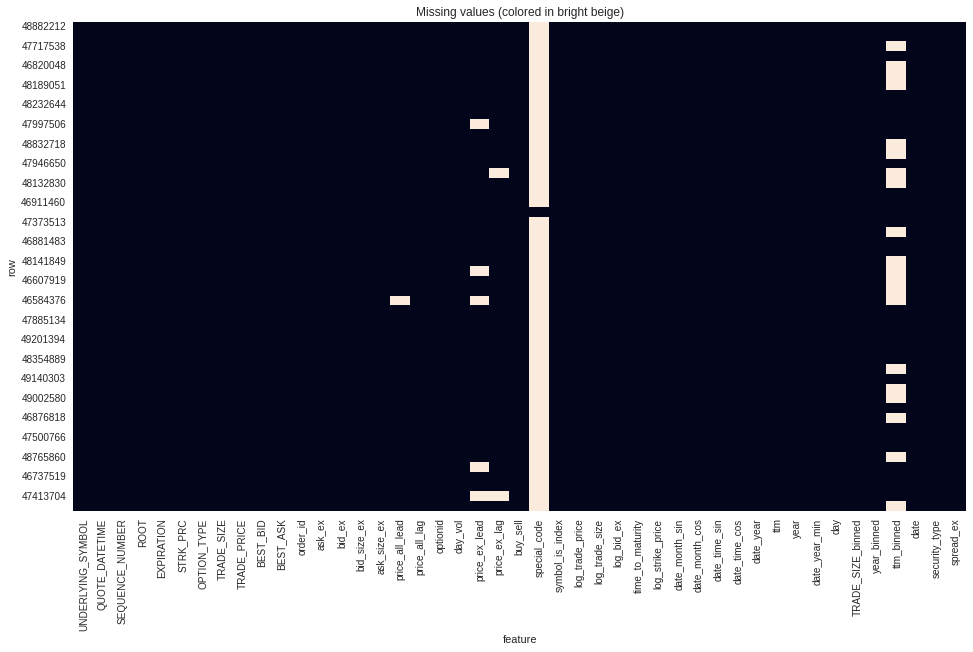

In [229]:
visualize_nan()

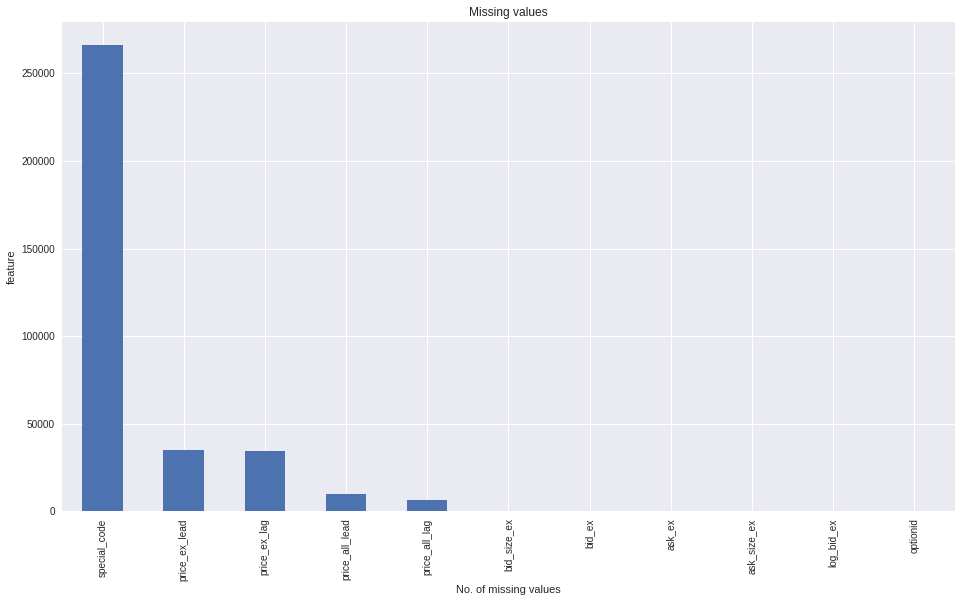

In [86]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(kind="bar", figsize=ratio, legend=False, 
                      xlabel="No. of missing values", 
                      ylabel="feature", 
                      title="Missing values")

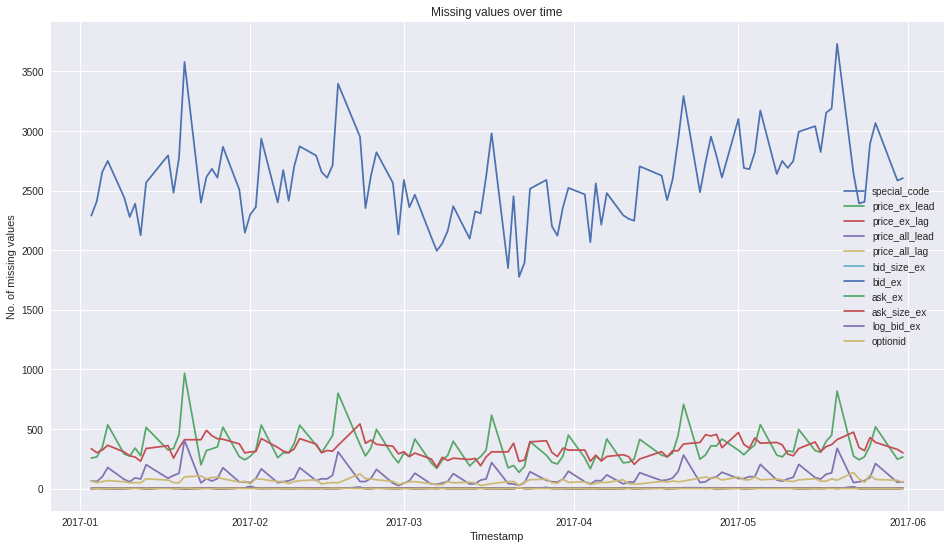

In [87]:
isna_vals_over_time = data[isna_vals.index.tolist()].groupby(data['QUOTE_DATETIME'].dt.date).agg(lambda x: x.isnull().sum())
isna_vals_over_time.plot(kind="line", figsize=ratio, title="Missing values over time", xlabel="Timestamp", ylabel="No. of missing values")

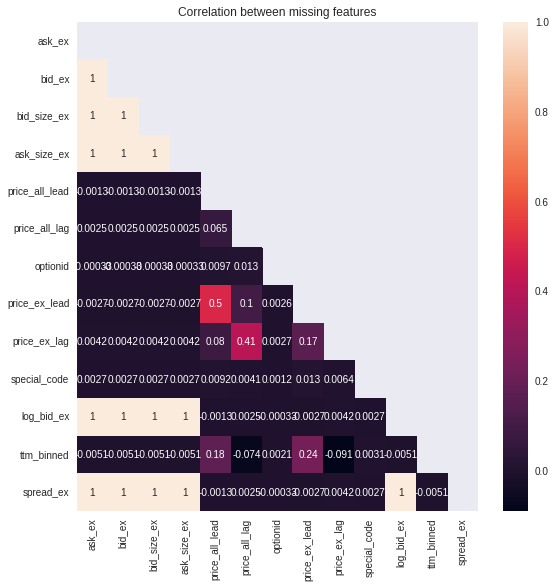

In [230]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[:, [i for i, n in enumerate(np.var(data.isnull(), axis='rows')) if n > 0]]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9,9)) 
ax = sns.heatmap(corr_mat, mask=mask, annot=True, annot_kws={'size':10}, ax=ax)
ax.title.set_text("Correlation between missing features")

In [89]:
# TODO: Check if there is a pattern between the missing values